# Installing and importing dependencies

In [ ]:
!pip install gerrychain
!pip install geopandas

     |████████████████████████████████| 54 kB 2.0 MB/s 
     |████████████████████████████████| 1.0 MB 10.1 MB/s 
     |████████████████████████████████| 6.3 MB 35.5 MB/s 
     |████████████████████████████████| 15.4 MB 49.7 MB/s 


In [ ]:
from gerrychain import Graph, Partition, Election
from gerrychain.updaters import Tally, cut_edges
import geopandas as gpd
import json

# Creating the initial graph

In [ ]:
df = gpd.read_file("utahPreprocessedPrecincts.json")
df.to_crs(inplace=True, crs="epsg:26918")
graph = Graph.from_geodataframe(df, ignore_errors=True, reproject=True)

/usr/local/lib/python3.7/dist-packages/gerrychain/graph/geo.py:12: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  utm_counts = Counter(utm_of_point(point) for point in wgs_df["geometry"].centroid)


[]


/usr/local/lib/python3.7/dist-packages/gerrychain/graph/adjacency.py:21: ShapelyDeprecationWarning: Setting custom attributes on geometry objects is deprecated, and will raise an AttributeError in Shapely 2.0
  geometries[i].id = i


In [ ]:
graph.to_json('utahGraph.json')

Eliminate Adjacencies that are less than 200 feet (60.96 meters)

In [ ]:
graph = json.load(open('utahGraph.json'))

In [ ]:
for i, edgeList in enumerate(graph['adjacency']):
  json_graph['adjacency'][i] = [d for d in edgeList if d['shared_perim'] >= 60.96]

with open('utahGraph2.json', 'w') as f:
  json.dump(graph, f, ensure_ascii=False)

In [ ]:
graph = Graph.from_json('utahGraph2.json')

# Creating the initial partition

In [ ]:
election = Election("20PRES", {"Dem": "DEMOCRAT", "Rep": "REPUBLICAN"})

initial_partition = Partition(
    graph,
    assignment="CD116",
    updaters={
        "cut_edges": cut_edges,
        "population": Tally("P0010001", alias="population"),
        "20PRES": election
    }
)

In [ ]:
for district, pop in initial_partition["population"].items():
  print("District {}: {}".format(district, pop))

District 01: 747377
District 08: 785631
District 03: 776100
District 07: 703666
District 02: 781599
District 06: 788544
District 04: 794853
District 05: 799454


# Running the markov chain

In [ ]:
from gerrychain import MarkovChain
from gerrychain.constraints import single_flip_contiguous
from gerrychain.proposals import propose_random_flip
from gerrychain.accept import always_accept

chain = MarkovChain(
    proposal=propose_random_flip,
    constraints=[],
    accept=always_accept,
    initial_state=initial_partition,
    total_steps=1000
)

In [ ]:
# for partition in chain:
#     print(sorted(partition["20PRES"].percents("Dem")))

In [ ]:
import pandas

d_percents = [sorted(partition["20PRES"].percents("Dem")) for partition in chain]

data = pandas.DataFrame(d_percents)

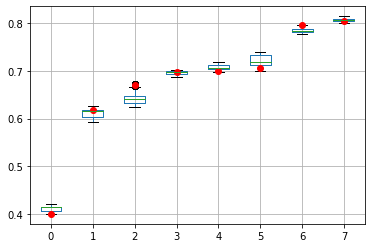

In [ ]:
import matplotlib.pyplot as plt

ax = data.boxplot(positions=range(len(data.columns)))
plt.plot(data.iloc[0], "ro")

plt.show()